In [20]:
%matplotlib inline

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score

from sklearn.linear_model import RidgeCV, LassoCV

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import scipy


In [21]:
# read in the training data
data_directory = "data/student_alcohol_grades"
train_data = pd.read_csv("{}/student-portugese-course.csv".format(data_directory), delimiter=";")
columns = train_data.columns
print(train_data.columns)


Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')


In [22]:
# define functions for massaing the data columns for preprocessing
def enumerate_feature(feature):
    count = 0
    known = []
    enumeration_map = {}
    for f in feature:
        if f not in known:
            known.append(f)
            enumeration_map[f] = count
            count += 1
    return enumeration_map

def massage(data):
    # replace yes and no answers with 1 and 0
    data = data.replace("yes", 1)
    data = data.replace("no",0)

    # enumerate categorical features
    categoricals = ["school", "sex", "address", "famsize", "Pstatus", "Mjob", "Fjob", "reason", "guardian"]

    # loop through all categorical features
    for feature in categoricals:
        # within each cateogrical feature, enumerate the different possible values of the feature
        enum_map = enumerate_feature(data[feature])
        for key in enum_map:
            data.ix[data[feature] == key, feature] = enum_map[key]
    return data

def histogram(x):
    max_y = x.max()
    plt.hist(x, bins=10, label="Data")
    plt.title("Histogram")
    [mean, median, _] = [np.mean(x), np.median(x), np.std(x)]
    plt.plot([mean, mean], [0, max_y], "r", label="Mean")
    plt.plot([median, median], [0, max_y], "g", label="Median")
    plt.legend(loc="upper right")


Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')


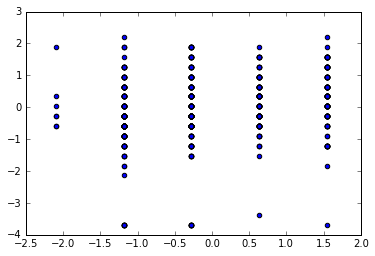

In [23]:
# massage and standardize the data in terms of standard deviations
train_data = massage(train_data)
scaler = preprocessing.StandardScaler().fit(train_data)
scaling = scaler.scale_[-1] * 5
train_data = pd.DataFrame(scaler.transform(train_data), columns=columns)
train = {
    "x": train_data.ix[:, :-1],
    "y": train_data.ix[:, -1]
}

print(columns)
plt.scatter(train_data["Fedu"], train["y"])

In [24]:
# obtain the test set of data
test_data = pd.read_csv("{}/student-math-course.csv".format(data_directory), delimiter=";")
test_data = massage(test_data)
test_data = pd.DataFrame(scaler.transform(test_data), columns=columns)
test = {
    "x": test_data.ix[:, :-1],
    "y": test_data.ix[:, -1]
}

In [25]:
# perform some regressions on the data, and report back a tuple of the R2 scores for each regressor
def evaluate(regressors, scoring_function, train, test):
    return [scoring_function(test["y"], regressor.fit(train["x"], train["y"]).predict(test["x"]))
            for regressor in regressors]

regressors = [RidgeCV(), LassoCV()]
evaluate(regressors, r2_score, train, test)


[0.78774257456953145, 0.78888388235484053]

(-1.0003660224930739, 1.0, -1.0003230633439055, 1.000510433169066)

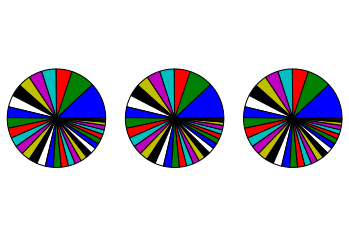

In [26]:
# can we reduce the dimension of the data? ... not really
from sklearn.decomposition import PCA, KernelPCA, RandomizedPCA
pca = PCA().fit(train["x"])
kpca = KernelPCA().fit(train["x"])
rpca = RandomizedPCA().fit(train["x"])

plt.subplot(1,3,1)
plt.pie(pca.explained_variance_ratio_)
plt.axis('equal')

plt.subplot(1,3,2)
plt.pie(kpca.lambdas_)
plt.axis('equal')

plt.subplot(1,3,3)
plt.pie(rpca.explained_variance_ratio_)
plt.axis('equal')

In [28]:
# take a look at the "best" predictors of the student's final grade
from sklearn.feature_selection import f_regression, SelectKBest

kbest = SelectKBest(f_regression, k=16).fit(train["x"], train["y"])
names_and_scores = [(columns[i], kbest.scores_[i]) for i in range(len(kbest.scores_))]
names_and_scores = sorted(names_and_scores, key=lambda x: x[1], reverse=True)
print(*names_and_scores[:5], sep='\n')

train["x"] = kbest.transform(train["x"])
test["x"] = kbest.transform(test["x"])
evaluate(regressors, r2_score, train, test)

('G2', 3493.2815663884453)
('G1', 1393.4667125605856)
('failures', 118.40612313279682)
('higher', 80.242452879063222)
('school', 56.89067686337134)


[0.78684245158682586, 0.78881133994206254]

0.91854800356
0.826387124789
-0.393315548042


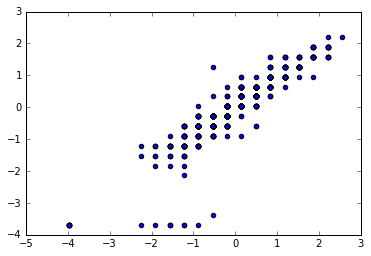

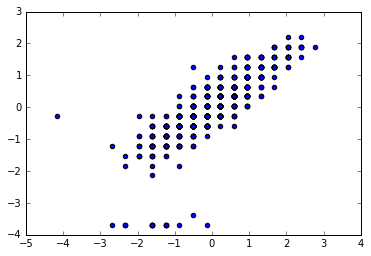

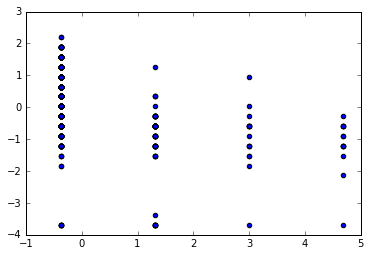

In [39]:
# compare the correlations between the best 3 features and the output prediction
# note the significant drop-off in correlation magnitude from "G1" to "failures", which mirrors well the
# significant drop-off in the SelectKBest scoring of the features
def measure_correlation(x, y):
    plt.scatter(x, y)
    print(scipy.stats.pearsonr(x, y)[0])
    
plt.figure()
measure_correlation(train_data["G2"], train_data.ix[:, -1])

plt.figure()
measure_correlation(train_data["G1"], train_data.ix[:, -1])

plt.figure()
measure_correlation(train_data["failures"], train_data.ix[:, -1])